Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

Begin Work - Feb 5, 2018 -mcliff

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import random
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from six.moves import cPickle as pickle
from six.moves import range
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory

assert(len(train_dataset) == len(train_labels))
assert(len(valid_dataset) == len(valid_labels))
assert(len(test_dataset) == len(test_labels))

print('Image Shape: {0}'.format(train_dataset[0].shape))
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Image Shape: (28, 28)
Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


label is 1


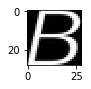

In [3]:
indx = random.randint(0, len(train_dataset))
image = train_dataset[indx].squeeze()
plt.figure(figsize=(1,1))
plt.imshow(image,cmap="gray")
print('label is {}'.format(train_labels[indx]))

Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale



#
# can I use
#  labels = tf.one_hot(labels, num_labels)


def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels


train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [5]:
def accuracy(predictions, labels):
  """expects predictions to be a object with ????
  """
  return (round(100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0],3))

## Modelling



Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

A Convolution,  takes an image and produces another image by appling a *weight* matrix to it (called the **kernel**) at each *point*, it then take a step (called *stride* to the next location).  In general if the stride is equal to 1 then the image is the *same* size (based on padding decisions it could be smaller). The weights of these convolution matrix are trained in the model, and essentially identify and help call out the **features** in the input data such as edges, or centers of mass.


In [6]:
#import os
# uses: 
#   image_size, num_channels, num_labels, train_labels
#  valid_dataset, test_dataset, # as consts 
def CN2Graph(batch_size=16, patch_size=5, depth=16, num_hidden=64,
             epochs = 1,
             display_step=50, verbose=False,
             the_training_dataset=train_dataset,
             the_training_labels=train_labels,
             the_validation_dataset=valid_dataset,
             the_validation_labels=valid_labels):
    """
    Creates a 2 Convolutional layer with one fully connected layer
    """

    #graph = tf.Graph()

    #with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(the_validation_dataset)
    keep_prob = tf.placeholder(tf.float32) # DROP OUT here 
  
    # Variables
    layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    
    layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    
    layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

        
    # input is a 4d tensor - [batches, width, height, channel==1]    
    # Model
    def model(data):
        # stride of 2 means we reduce the next layer to 14x14  (we have x16 for depth)
        # input is data-16x28x28x1 ;  w1 - 5x5x1x16 [Hgt,Wght,In-Chan,Out-Chan]
        #   output is 16x14x14x16;  b1 is 16x1 (one for each of the depth on convultion)
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        # again a stride of 2 reduces us to 7x7, and now we have 16 channels for each depth layer
        # hidden is 16x14x14x16   ;   w2 is 5x5x16x16; b2 is 16x1
        #   output is 16x7x7x16
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        shape = hidden.get_shape().as_list()
        #  reshape now to 16x784    basically push all the layers and pixels into a giant list
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        # w3 is 784x64, b3 is 64x1  (standard fully connected)
        # hidden is 16x64
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        
        # w4 is 64x10, b4 is 10x1; result here is 16x1 these are the logit numbers
        return tf.matmul(hidden, layer4_weights) + layer4_biases
        
    logits = model(tf_train_dataset)
        
    # Training computation.
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
        
        
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        saver = tf.train.Saver()

        print('Training for {0} epochs'.format(epochs))
        
        
        retAcc = []
        for i in range(epochs):
            
            the_training_dataset, the_training_labels = shuffle(the_training_dataset, the_training_labels)
            for offset in range(0, (len(the_training_dataset) - batch_size), batch_size):
            #for offset in range(0, batch_size*500, batch_size):
            #for step in range(500):
                # on each step pull a different subset
            
            
                #offset = (step * batch_size) % (train_labels.shape[0] - batch_size) # what is train_labels.shape[0] ?
                end = offset + batch_size
                #batch_data = the_training_dataset[offset:end, :, :, :]
                #batch_labels = the_training_labels[offset:end,:]
                batch_data, batch_labels = the_training_dataset[offset:end], the_training_labels[offset:end]
            
                # this is what we actually feed into the graph above
                feed_dict = {
                    tf_train_dataset : batch_data,
                    tf_train_labels : batch_labels
                }
                # local vars l and preductions get returned from graph variables 'loss' and 'train_prediction'
                #    'optimizer' is also evaluated in the graph
                _, l, predictions = session.run(
                    [optimizer, loss, train_prediction], feed_dict=feed_dict
                )
            
                if (offset % (batch_size * display_step) == 0):
                    if verbose:
                        print('Accuracy (Batch/Validation): %5.1f%% %5.1f%%\tloss at epoch %d, step %d: %f' % 
                              (accuracy(predictions, batch_labels),
                               accuracy(valid_prediction.eval(), valid_labels), i, offset/batch_size, l))
                    retAcc.append( (i, int(offset/batch_size), accuracy(valid_prediction.eval(), the_validation_labels)) )
            if verbose:
                print('end of epoch {0}'.format(i))

        #print('current path {0}'.format(os.getcwd()))
        saver.save(session, './cnn')
    return(retAcc)
    

In [7]:
#(batch_size=16, patch_size=5, depth=16, num_hidden=64,
#epochs = 1,
#display_step=50, verbose=False):
CN2Graph()

Training for 1 epochs


[(0, 0, 10.0),
 (0, 50, 54.060000000000002),
 (0, 100, 72.969999999999999),
 (0, 150, 75.349999999999994),
 (0, 200, 78.370000000000005),
 (0, 250, 77.769999999999996),
 (0, 300, 78.900000000000006),
 (0, 350, 78.099999999999994),
 (0, 400, 80.200000000000003),
 (0, 450, 80.560000000000002),
 (0, 500, 80.849999999999994),
 (0, 550, 81.909999999999997),
 (0, 600, 82.409999999999997),
 (0, 650, 81.909999999999997),
 (0, 700, 83.049999999999997),
 (0, 750, 82.340000000000003),
 (0, 800, 81.400000000000006),
 (0, 850, 82.730000000000004),
 (0, 900, 83.340000000000003),
 (0, 950, 82.810000000000002),
 (0, 1000, 83.590000000000003),
 (0, 1050, 83.549999999999997),
 (0, 1100, 83.930000000000007),
 (0, 1150, 83.719999999999999),
 (0, 1200, 83.950000000000003),
 (0, 1250, 83.430000000000007),
 (0, 1300, 83.890000000000001),
 (0, 1350, 84.450000000000003),
 (0, 1400, 84.719999999999999),
 (0, 1450, 83.969999999999999),
 (0, 1500, 84.599999999999994),
 (0, 1550, 84.269999999999996),
 (0, 1600, 83

In [8]:
cn = CN2Graph(batch_size=256, verbose=True, epochs=2)
cn

Training for 2 epochs
Accuracy (Batch/Validation):  10.5%  16.8%	loss at epoch 0, step 0: 3.145647
Accuracy (Batch/Validation):  80.1%  77.5%	loss at epoch 0, step 50: 0.707979
Accuracy (Batch/Validation):  78.5%  77.0%	loss at epoch 0, step 100: 0.748178
Accuracy (Batch/Validation):  80.1%  81.1%	loss at epoch 0, step 150: 0.734497
Accuracy (Batch/Validation):  83.6%  81.0%	loss at epoch 0, step 200: 0.691428
Accuracy (Batch/Validation):  81.2%  81.2%	loss at epoch 0, step 250: 0.693282
Accuracy (Batch/Validation):  84.0%  82.3%	loss at epoch 0, step 300: 0.647681
Accuracy (Batch/Validation):  83.2%  82.6%	loss at epoch 0, step 350: 0.632382
Accuracy (Batch/Validation):  86.3%  83.4%	loss at epoch 0, step 400: 0.524066
Accuracy (Batch/Validation):  84.4%  83.4%	loss at epoch 0, step 450: 0.476929
Accuracy (Batch/Validation):  89.5%  83.9%	loss at epoch 0, step 500: 0.402310
Accuracy (Batch/Validation):  83.2%  84.3%	loss at epoch 0, step 550: 0.558039
Accuracy (Batch/Validation):  84.

[(0, 0, 16.75),
 (0, 50, 77.519999999999996),
 (0, 100, 76.950000000000003),
 (0, 150, 81.129999999999995),
 (0, 200, 81.040000000000006),
 (0, 250, 81.25),
 (0, 300, 82.280000000000001),
 (0, 350, 82.569999999999993),
 (0, 400, 83.390000000000001),
 (0, 450, 83.439999999999998),
 (0, 500, 83.909999999999997),
 (0, 550, 84.319999999999993),
 (0, 600, 84.590000000000003),
 (0, 650, 84.370000000000005),
 (0, 700, 85.180000000000007),
 (0, 750, 85.129999999999995),
 (1, 0, 84.989999999999995),
 (1, 50, 85.049999999999997),
 (1, 100, 84.549999999999997),
 (1, 150, 85.900000000000006),
 (1, 200, 85.939999999999998),
 (1, 250, 86.159999999999997),
 (1, 300, 85.900000000000006),
 (1, 350, 86.239999999999995),
 (1, 400, 86.349999999999994),
 (1, 450, 86.549999999999997),
 (1, 500, 86.519999999999996),
 (1, 550, 86.560000000000002),
 (1, 600, 86.659999999999997),
 (1, 650, 86.400000000000006),
 (1, 700, 86.849999999999994),
 (1, 750, 86.980000000000004)]

In [9]:

# uses: 
#   image_size, num_channels, num_labels, train_labels
#  valid_dataset, # as consts 
def ModelCNN(batch_size=16, patch_size=5, depth=16, num_hidden=64, 
              num_steps = 1001, display_step=50, verbose=False):
    """
    Creates a 2 Convolutional layer with one fully connected layer
    """

    graph = tf.Graph()
    with graph.as_default():

        # Input data.
        tf_train_dataset = tf.placeholder(
            tf.float32, shape=(batch_size, image_size, image_size, num_channels))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        #tf_test_dataset = tf.constant(test_dataset)
        keep_prob = tf.placeholder(tf.float32) # DROP OUT here 
  
        # Variables
        layer1_weights = tf.Variable(tf.truncated_normal(
          [patch_size, patch_size, num_channels, depth], stddev=0.1))
        
        layer1_biases = tf.Variable(tf.zeros([depth]))
    
        layer2_weights = tf.Variable(tf.truncated_normal(
          [patch_size, patch_size, depth, depth], stddev=0.1))
        layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    
        layer3_weights = tf.Variable(tf.truncated_normal(
          [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
        layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
        layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
        layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

        
        
        # Model
        def model(data):
            # 
            conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
            hidden = tf.nn.relu(conv + layer1_biases)
            conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
            hidden = tf.nn.relu(conv + layer2_biases)
            shape = hidden.get_shape().as_list()
            reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
            hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        
            return tf.matmul(hidden, layer4_weights) + layer4_biases
        
        logits = model(tf_train_dataset)
        
        # Training computation.
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
        # Optimizer.
        optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
        #test_prediction = tf.nn.softmax(model(tf_test_dataset))
        
        
    with tf.Session(graph = graph) as session:
        session.run(tf.global_variables_initializer())

        retAcc = []
        for step in range(num_steps):
            # on each step pull a different subset
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size) # what is train_labels.shape[0] ?
            batch_data = train_dataset[offset:(offset+batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset+batch_size),:]
            
            # this is what we actually feed into the graph above
            feed_dict = {
                tf_train_dataset : batch_data,
                tf_train_labels : batch_labels
            }
            # local vars l and preductions get returned from graph variables 'loss' and 'train_prediction'
            #    'optimizer' is also evaluated in the graph
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict
            )
            
            if (step % display_step == 0):
                if verbose:
                    print('Accuracy (Batch/Validation): %5.1f%% %5.1f%%\tloss at step %d: %f' % 
                          (accuracy(predictions, batch_labels),
                           accuracy(valid_prediction.eval(), valid_labels),
                           step, l))
                retAcc.append(accuracy(valid_prediction.eval(), valid_labels))

            
    return(retAcc)
    

In [10]:
cnn = ModelCNN(num_steps=1001, display_step=50)
cnn

[14.890000000000001,
 67.769999999999996,
 76.409999999999997,
 76.310000000000002,
 79.280000000000001,
 78.239999999999995,
 79.599999999999994,
 78.560000000000002,
 80.400000000000006,
 79.219999999999999,
 80.659999999999997,
 80.530000000000001,
 82.090000000000003,
 82.150000000000006,
 82.329999999999998,
 82.510000000000005,
 82.849999999999994,
 83.030000000000001,
 83.040000000000006,
 83.129999999999995,
 83.030000000000001]

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

Side Note: per this article we should never use sigmoids because they "saturate and die"
http://cs231n.github.io/neural-networks-1/

In [11]:

# uses: 
#   image_size, num_channels, num_labels, train_labels
#  valid_dataset, test_dataset, # as consts 
#
# patch_size - 2*kernel_size + 1;  used for convolution
#
def MaxPoolModel(batch_size=16, patch_size=5, depth=16, num_hidden=64,
                 validation_dataset=valid_dataset, verbose=True, 
                 display_step=50, num_steps = 1001):
    """
    Creates a 2 Convolutional layer with one fully connected layer
    """

    #graph = tf.Graph()

    #with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(validation_dataset)
    keep_prob = tf.placeholder(tf.float32) # DROP OUT here 
  
    # Variables
    layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    
    layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    
    layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

        
        
    # Model
    def model(data):
        # input 16x28x28x1; output is 16x28x28x16
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        # input is 16x28x28x16, output is 16x14x14x16
        max_reduce = tf.nn.max_pool(conv, [1,2,2,1], [1, 2, 2, 1], padding='SAME')       
        # l1 is 16x1
        hidden = tf.nn.relu(max_reduce + layer1_biases)
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')

        max_reduce = tf.nn.max_pool(conv, [1,2,2,1], [1, 2, 2, 1], padding='SAME')       
        

        hidden = tf.nn.relu(max_reduce + layer2_biases)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        
        return tf.matmul(hidden, layer4_weights) + layer4_biases
        
    logits = model(tf_train_dataset)
        
    # Training computation.
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
        


    retAcc = []
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        
        for step in range(num_steps):
            # on each step pull a different subset
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size) # what is train_labels.shape[0] ?
            batch_data = train_dataset[offset:(offset+batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset+batch_size),:]
            
            # this is what we actually feed into the graph above
            feed_dict = {
                tf_train_dataset : batch_data,
                tf_train_labels : batch_labels
            }
            # local vars l and preductions get returned from graph variables 'loss' and 'train_prediction'
            #    'optimizer' is also evaluated in the graph
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict
            )
            
            if (step % display_step == 0):
                if verbose:
                    print('Accuracy (Batch/Validation): %5.1f%% %5.1f%%\tloss at step %d: %f' % 
                          (accuracy(predictions, batch_labels),
                           accuracy(valid_prediction.eval(), valid_labels),
                           step, l))                
            
                retAcc.append(accuracy(valid_prediction.eval(), valid_labels))

            
    return(retAcc)         
    

In [12]:
pool = MaxPoolModel(num_steps=1001, display_step=50, verbose=False)
pool

[10.029999999999999,
 57.710000000000001,
 70.450000000000003,
 76.129999999999995,
 77.489999999999995,
 79.670000000000002,
 81.359999999999999,
 79.349999999999994,
 81.420000000000002,
 80.969999999999999,
 82.829999999999998,
 83.370000000000005,
 83.359999999999999,
 83.510000000000005,
 83.670000000000002,
 84.430000000000007,
 83.950000000000003,
 83.969999999999999,
 84.680000000000007,
 84.780000000000001,
 84.200000000000003]

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

reference [LeNet in TensorFlow](https://github.com/sujaybabruwad/LeNet-in-Tensorflow)

**Specs**

- Input Image is 28x28x1 and converted to 32x32x1 as per LeNet requirements.
- Convolution layer 1: The output shape should be 28x28x6.
- Activation 1: Your choice of activation function.
- Pooling layer 1: The output shape should be 14x14x6.
- Convolution layer 2: The output shape should be 10x10x16.
- Activation 2: Your choice of activation function.
- Pooling layer 2: The output shape should be 5x5x16.
- Flatten layer: Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.
- Fully connected layer 1: This should have 120 outputs.
- Activation 3: Your choice of activation function.
- Fully connected layer 2: This should have 10 outputs.
- Return the result of the 2nd fully connected layer from the LeNet function.

---

In [13]:

def LogitLeNet5(x):
    """
    Input a 4D tensor;
    Output 4D tensor to use for Logit in Loss optimization
    """
    # used for sedding weights and bias
    mu = 0
    sigma = 0.1
    
    # layer1 - convolution (we should use VALID padding and got 32x32 - 28x28; 
    #    since we have 28x28 input use SAME padding)
    #   6 depth layers, and 2 dimension kernel (5x5 filter)
    conv1_w = tf.Variable(tf.truncated_normal(shape=[5,5,1,6], mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_w, strides=[1,1,1,1], padding='SAME') + conv1_b
    
    # now run the activation function
    # output is Nx28x28x6
    conv1 = tf.nn.relu(conv1)
    
    # (max) pooling to reduce dimension
    # input is Nx28x28x6, out is Nx14x14x6
    pool_1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    # 2nd convolution, going from 6 in-depth to 16 out-depth
    #   use VALID padding to step down so output is Nx10x10x16
    conv2_w = tf.Variable(tf.truncated_normal(shape=[5,5,6,16], mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(pool_1, conv2_w, strides=[1,1,1,1], padding='VALID') + conv2_b
    
    # another activation
    conv2 = tf.nn.relu(conv2)
    
    # pooling again to reduce dimension
    # output dimension is Nx5x5x16
    pool_2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    # flatten the input from Nx5x5x16 to Nx400
    fc1 = flatten(pool_2)
    
    # run a fully connected Neural Net layer; maps to 120 hidden layer1
    #  we'll mapp the 5x5x16 -> 400 input to 120 output nodes for this layer
    # input Nx5x5x16 -> output  Nx120
    fc1_w = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc1, fc1_w) + fc1_b
    
    # run the activation function on this layer (wihtout this, we're just doing linear regressions)
    fc1 = tf.nn.relu(fc1)
    
    # another fully connected layer, 120 -> 84, maps to 84 hidden layer2
    fc2_w = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_w) + fc2_b
    
    # activation
    fc2 = tf.nn.relu(fc2)
    
    # final layer 84 -> 10
    fc3_w = tf.Variable(tf.truncated_normal(shape=(84, 10), mean=mu, stddev=sigma))
    fc3_b = tf.Variable(tf.zeros(10))
    logits = tf.matmul(fc2, fc3_w) + fc3_b
    return logits




def ModelLeNet5(batch_size=128, epochs=1, 
                the_training_dataset=train_dataset, 
                the_training_labels=train_labels,
                the_validation_dataset=valid_dataset, 
                the_validation_labels=valid_labels,
                verbose=True, 
                display_step=50):    

    
    #x = tf.placeholder(tf.float32, (None, 32, 32, 1))
    #y = tf.placeholder(tf.int32, (None))
    #one_hot_y = tf.one_hot(y, 10)

        # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    #tf_valid_dataset = tf.constant(validation_dataset)

    
    rate = 0.001
    logits = LogitLeNet5(tf_train_dataset)

    # Training computation.
    #loss = tf.reduce_mean(
    #    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
    loss_op = tf.reduce_mean(cross_entropy)
    
    # Optimizer.
    #optimizer = tf.train.AdamOptimizer(learning_rate = rate).minimize(loss)
    optimizer = tf.train.AdamOptimizer(learning_rate = rate)
    training_op = optimizer.minimize(loss_op)

    # Predictions for the training, validation, and test data.
    #train_prediction = tf.nn.softmax(logits)
    #valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(tf_train_labels, 1))  
    accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    # to save the model to run on the test data later
    saver = tf.train.Saver()
    
    def evaluate(X_data, y_data):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        # do we have to be even multiples here?
        for offset in range(0, (num_examples-batch_size), batch_size):  # BATCH_SIZE=128
            end = offset + batch_size
            batch_x, batch_y = X_data[offset:end], y_data[offset:end]
            accuracy = sess.run(accuracy_op, 
                                feed_dict={ tf_train_dataset: batch_x, tf_train_labels: batch_y })
            total_accuracy += (accuracy * len(batch_x))
        return round(total_accuracy /  num_examples, 3)
    
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        num_examples = len(the_training_dataset)
        
        print("Training....")
        retAcc = []
        for i in range(epochs):
            the_training_dataset, the_training_labels = shuffle(the_training_dataset, the_training_labels)
            
            for offset in range(0, (num_examples-batch_size), batch_size):
                end = offset + batch_size
                batch_x, batch_y = the_training_dataset[offset:end], the_training_labels[offset:end]
                session.run(training_op,
                        feed_dict={ tf_train_dataset: batch_x, tf_train_labels: batch_y})
                
                validation_accuracy = evaluate(the_validation_dataset, the_validation_labels)
                
                step = int(offset/batch_size)
                if step % display_step == 0:
                    if verbose:
                        print('Accuracy (Validation): %f at epoch %d, step %d' % 
                               (validation_accuracy, i, step))
                    retAcc.append( (i, step, validation_accuracy) )
                        
                        
        saver.save(session, './lenet')
    return(retAcc)
        
        

In [14]:
model_lenet5 = ModelLeNet5(epochs=5)
model_lenet5

Training....
Accuracy (Validation): 0.126000 at epoch 0, step 0
Accuracy (Validation): 0.749000 at epoch 0, step 50
Accuracy (Validation): 0.798000 at epoch 0, step 100
Accuracy (Validation): 0.814000 at epoch 0, step 150
Accuracy (Validation): 0.822000 at epoch 0, step 200
Accuracy (Validation): 0.832000 at epoch 0, step 250
Accuracy (Validation): 0.838000 at epoch 0, step 300
Accuracy (Validation): 0.844000 at epoch 0, step 350
Accuracy (Validation): 0.856000 at epoch 0, step 400
Accuracy (Validation): 0.849000 at epoch 0, step 450
Accuracy (Validation): 0.857000 at epoch 0, step 500
Accuracy (Validation): 0.862000 at epoch 0, step 550
Accuracy (Validation): 0.860000 at epoch 0, step 600
Accuracy (Validation): 0.865000 at epoch 0, step 650
Accuracy (Validation): 0.862000 at epoch 0, step 700
Accuracy (Validation): 0.865000 at epoch 0, step 750
Accuracy (Validation): 0.870000 at epoch 0, step 800
Accuracy (Validation): 0.869000 at epoch 0, step 850
Accuracy (Validation): 0.872000 at e

Accuracy (Validation): 0.908000 at epoch 4, step 1300
Accuracy (Validation): 0.907000 at epoch 4, step 1350
Accuracy (Validation): 0.906000 at epoch 4, step 1400
Accuracy (Validation): 0.909000 at epoch 4, step 1450
Accuracy (Validation): 0.909000 at epoch 4, step 1500
Accuracy (Validation): 0.912000 at epoch 4, step 1550


[(0, 0, 0.126),
 (0, 50, 0.749),
 (0, 100, 0.79800000000000004),
 (0, 150, 0.81399999999999995),
 (0, 200, 0.82199999999999995),
 (0, 250, 0.83199999999999996),
 (0, 300, 0.83799999999999997),
 (0, 350, 0.84399999999999997),
 (0, 400, 0.85599999999999998),
 (0, 450, 0.84899999999999998),
 (0, 500, 0.85699999999999998),
 (0, 550, 0.86199999999999999),
 (0, 600, 0.85999999999999999),
 (0, 650, 0.86499999999999999),
 (0, 700, 0.86199999999999999),
 (0, 750, 0.86499999999999999),
 (0, 800, 0.87),
 (0, 850, 0.86899999999999999),
 (0, 900, 0.872),
 (0, 950, 0.873),
 (0, 1000, 0.876),
 (0, 1050, 0.875),
 (0, 1100, 0.88100000000000001),
 (0, 1150, 0.878),
 (0, 1200, 0.877),
 (0, 1250, 0.879),
 (0, 1300, 0.879),
 (0, 1350, 0.88200000000000001),
 (0, 1400, 0.88100000000000001),
 (0, 1450, 0.878),
 (0, 1500, 0.88200000000000001),
 (0, 1550, 0.88100000000000001),
 (1, 0, 0.88200000000000001),
 (1, 50, 0.88700000000000001),
 (1, 100, 0.88600000000000001),
 (1, 150, 0.88300000000000001),
 (1, 200, 0

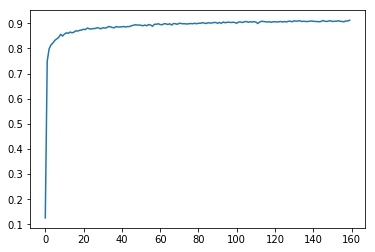

In [15]:
acc = [x[2] for x in model_lenet5]
plt.plot(acc)